# PrimeKG Pathfinding Algorithm Benchmark

**Purpose:** Evaluate graph pathfinding algorithms for drug mechanism-of-action (MoA) discovery by comparing predicted mechanistic pathways against curated ground truth pathways from DrugMechDB.

**Algorithms Benchmarked:**
1. **Shortest Path** — Unweighted BFS baseline
2. **Hub-Penalized Shortest Path** — Penalizes high-degree hub nodes
3. **PageRank-Inverse Shortest Path** — Prefers low-centrality (specific) nodes
4. **Learned Embeddings + A\*** — Supervised edge weights from spectral embeddings
5. **Semantic Bridging** — TF-IDF cosine similarity edge weighting

**Evaluation Metrics (9 total):**

| Category | Metrics | What It Measures |
|----------|---------|------------------|
| Node Accuracy | Precision, Recall, F1 | Are the right nodes in the path? |
| Target Finding | Hits@1, Hits@3, Hits@5 | Does the path reach the disease? |
| Mechanistic Quality | Relation Accuracy, Edit Distance, Hub Ratio | Is the path biologically valid? |

> **Note:** This notebook is fully self-contained — all algorithms, evaluation helpers, and metrics are defined inline. No external `.py` imports required.

> **Filter:** Only ground truth pathways with **≥ 4 nodes** are included (short 2-3 node drug→protein→disease paths are excluded).


## 1. Setup & Imports

In [31]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import time
import warnings

from typing import Dict, List, Tuple
from collections import Counter
from scipy.sparse.linalg import eigsh
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

warnings.filterwarnings('ignore')
print("✓ All imports loaded")


✓ All imports loaded


## 2. Configuration

In [32]:
# === CONFIGURE PATHS ===
# Update DATA_DIR to your project root
DATA_DIR = '.'

PATHS = {
    'nodes':              f'{DATA_DIR}/data/raw/nodes.csv',
    'edges':              f'{DATA_DIR}/data/raw/edges.csv',
    'ground_truth_nodes': f'{DATA_DIR}/data/processed/benchmark_pathways_nodes.csv',
    'ground_truth_edges': f'{DATA_DIR}/data/processed/benchmark_pathways_edges.csv',
}

# Minimum pathway length filter — only keep pathways with >= this many nodes
MIN_PATHWAY_NODES = 4

# Quick sanity check: verify files exist
import os
print("Configuration:")
for name, path in PATHS.items():
    exists = "✓" if os.path.exists(path) else "✗ NOT FOUND"
    print(f"  {exists}  {name}: {path}")
print(f"  min_pathway_nodes: {MIN_PATHWAY_NODES}")


import subprocess
result = subprocess.run(['find', '.', '-name', 'benchmark_pathways_nodes.csv'], capture_output=True, text=True)
print(result.stdout)

Configuration:
  ✓  nodes: ./data/raw/nodes.csv
  ✓  edges: ./data/raw/edges.csv
  ✓  ground_truth_nodes: ./data/processed/benchmark_pathways_nodes.csv
  ✓  ground_truth_edges: ./data/processed/benchmark_pathways_edges.csv
  min_pathway_nodes: 4
./data/processed/benchmark_pathways_nodes.csv



## 3. Evaluation Helpers

All helper functions for computing metrics — inlined so the notebook is fully self-contained.


In [33]:
# ============================================================
# EVALUATION HELPERS
# ============================================================

def is_valid_prediction(predicted_ids):
    """Check if prediction is valid (not empty or 'NONE')."""
    return predicted_ids and predicted_ids != ['NONE']


def calculate_edit_distance(predicted_ids, ground_truth_ids):
    """
    Normalized Levenshtein edit distance between two sequences.
    Returns value in [0, 1] where 0 = identical, 1 = completely different.
    """
    if not predicted_ids or predicted_ids == ['NONE']:
        return 1.0
    m, n = len(predicted_ids), len(ground_truth_ids)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if predicted_ids[i - 1] == ground_truth_ids[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
    return dp[m][n] / max(m, n)


def compute_degree_counts(edges_df):
    """
    Compute degree count for all nodes from edges DataFrame.
    Columns: x_index, y_index
    """
    degree_count = Counter()
    for _, row in edges_df.iterrows():
        degree_count[row['x_index']] += 1
        degree_count[row['y_index']] += 1
    return degree_count


def compute_hub_threshold(degree_count, percentile=95):
    """Compute hub threshold at given percentile of degree distribution."""
    all_degrees = list(degree_count.values())
    return np.percentile(all_degrees, percentile)


def calculate_hits_at_k(predicted_ids, ground_truth_target, k_values=[1, 3, 5]):
    """
    Check if the target appears in the last k nodes of the predicted path.
    """
    hits = {f'hits_at_{k}': 0 for k in k_values}
    if not is_valid_prediction(predicted_ids):
        return hits
    for k in k_values:
        last_k = predicted_ids[-k:] if len(predicted_ids) >= k else predicted_ids
        hits[f'hits_at_{k}'] = 1 if ground_truth_target in last_k else 0
    return hits


def calculate_relation_accuracy(predicted_relations, ground_truth_edge_types):
    """Fraction of predicted edge types that appear in the ground truth set."""
    if not predicted_relations:
        return 0.0
    gt_types = set(ground_truth_edge_types)
    matches = sum(1 for r in predicted_relations if r in gt_types)
    return matches / len(predicted_relations)


def calculate_path_length_mae(predicted_length, ground_truth_length):
    """Absolute error between predicted and ground truth path lengths."""
    return abs(predicted_length - ground_truth_length)


def calculate_hub_node_ratio(predicted_indices, degree_count, hub_threshold):
    """Fraction of predicted path nodes that are high-degree hubs."""
    if not predicted_indices:
        return 0.0
    hub_count = sum(1 for idx in predicted_indices if degree_count.get(idx, 0) >= hub_threshold)
    return hub_count / len(predicted_indices)


print("✓ Evaluation helpers loaded")


✓ Evaluation helpers loaded


## 4. Evaluation Metrics

Nine metrics across three categories: node accuracy, target finding, and mechanistic quality.


In [34]:
# ============================================================
# EVALUATION METRICS
# ============================================================

def metric_precision(predicted_ids, ground_truth_ids):
    """Fraction of predicted nodes that are correct: |pred ∩ gt| / |pred|"""
    if not is_valid_prediction(predicted_ids):
        return 0.0
    pred_set, gt_set = set(predicted_ids), set(ground_truth_ids)
    return len(pred_set & gt_set) / len(pred_set)


def metric_recall(predicted_ids, ground_truth_ids):
    """Fraction of ground truth nodes recovered: |pred ∩ gt| / |gt|"""
    if not is_valid_prediction(predicted_ids):
        return 0.0
    pred_set, gt_set = set(predicted_ids), set(ground_truth_ids)
    return len(pred_set & gt_set) / len(gt_set) if gt_set else 0.0


def metric_f1(predicted_ids, ground_truth_ids):
    """Harmonic mean of precision and recall."""
    p = metric_precision(predicted_ids, ground_truth_ids)
    r = metric_recall(predicted_ids, ground_truth_ids)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)


def metric_path_length_accuracy(predicted_length, ground_truth_length):
    """1 - |pred_len - gt_len| / max(pred_len, gt_len). Returns [0,1], 1 = exact."""
    if predicted_length == 0 and ground_truth_length == 0:
        return 1.0
    max_len = max(predicted_length, ground_truth_length)
    if max_len == 0:
        return 0.0
    return 1 - abs(predicted_length - ground_truth_length) / max_len


def metric_hub_node_ratio(predicted_indices, degree_count, hub_threshold):
    """Fraction of path nodes that are hubs. Lower is better."""
    if not predicted_indices:
        return 0.0
    hub_count = sum(1 for idx in predicted_indices if degree_count.get(idx, 0) >= hub_threshold)
    return hub_count / len(predicted_indices)


def metric_mrr(predicted_ids, ground_truth_ids):
    """Mean Reciprocal Rank — 1 / rank of first correct node. Higher is better."""
    if not is_valid_prediction(predicted_ids):
        return 0.0
    gt_set = set(ground_truth_ids)
    for rank, node in enumerate(predicted_ids, start=1):
        if node in gt_set:
            return 1 / rank
    return 0.0


def metric_speed(run_fn, *args, **kwargs):
    """Time a function call in milliseconds. Returns (result, elapsed_ms)."""
    start = time.perf_counter()
    result = run_fn(*args, **kwargs)
    elapsed_ms = (time.perf_counter() - start) * 1000
    return result, elapsed_ms


print("✓ Evaluation metrics loaded")


✓ Evaluation metrics loaded


## 5. Pathfinding Algorithms

All five algorithms defined inline. They share a common `find_path_engine` (constrained Dijkstra) and `allowed_transition` filter that prevents shortcut edges.


In [35]:
# ============================================================
# SHARED: TRANSITION FILTER & DIJKSTRA ENGINE
# ============================================================

def allowed_transition(G, src, u, v) -> bool:
    """
    Block shortcut transitions:
      (1) drug → disease (anywhere in path)
      (2) drug → drug (when source is a drug — prevents drug→drug→disease)
    """
    u_type = G.nodes[u].get("node_type", "")
    v_type = G.nodes[v].get("node_type", "")

    # Ban drug → disease
    if u_type == "drug" and v_type == "disease":
        return False

    # Ban drug → drug at first hop from a drug source
    src_type = G.nodes[src].get("node_type", "")
    if src_type == "drug" and u == src and v_type == "drug":
        return False

    return True


def find_path_engine(graph, weighted_graph, source, target, transition_fn):
    """
    Generic constrained Dijkstra shortest-path engine.

    Parameters
    ----------
    graph          : nx.DiGraph — original graph (for node_type, relation lookup)
    weighted_graph : nx.DiGraph — graph with edge 'weight' attribute
    source, target : int
    transition_fn  : callable(G, source, u, v) -> bool

    Returns
    -------
    path_nodes, relations, total_cost
    """
    dist = {source: 0.0}
    parent = {source: None}
    pq = [(0.0, source)]

    while pq:
        cur_cost, u = heapq.heappop(pq)
        if cur_cost != dist.get(u, float('inf')):
            continue
        if u == target:
            break
        for v in graph.successors(u):
            if not transition_fn(graph, source, u, v):
                continue
            w = weighted_graph[u][v].get("weight", 1.0)
            new_cost = cur_cost + w
            if new_cost < dist.get(v, float('inf')):
                dist[v] = new_cost
                parent[v] = u
                heapq.heappush(pq, (new_cost, v))

    if target not in dist:
        return [], [], float("inf")

    # Reconstruct path
    path = []
    cur = target
    while cur is not None:
        path.append(cur)
        cur = parent[cur]
    path.reverse()

    # Reconstruct relations
    relations = []
    for i in range(len(path) - 1):
        edge_data = graph.get_edge_data(path[i], path[i + 1]) or {}
        relations.append(edge_data.get("relation", "unknown"))

    return path, relations, dist[target]


print("✓ Shared engine loaded: allowed_transition + find_path_engine")


✓ Shared engine loaded: allowed_transition + find_path_engine


In [36]:
# ============================================================
# ALGORITHM 2: Hub-Penalized Weighted Shortest Path
# ============================================================
# Weight: w(u,v) = 1 + α · log(degree(v))

class HubPenalizedShortestPath:
    def __init__(self, graph: nx.DiGraph, alpha: float = 0.5):
        self.graph = graph
        self.alpha = alpha
        self.weighted_graph = self._compute_weights()

    def _compute_weights(self) -> nx.DiGraph:
        G_w = self.graph.copy()
        degrees = dict(G_w.degree())
        for u, v in G_w.edges():
            deg_v = degrees.get(v, 1)
            G_w[u][v]['weight'] = 1.0 + self.alpha * np.log(max(deg_v, 1))
            
        return G_w

    def find_path(self, source: int, target: int):
        return find_path_engine(self.graph, self.weighted_graph, source, target, allowed_transition)


print("✓ HubPenalizedShortestPath loaded")


✓ HubPenalizedShortestPath loaded


In [37]:
# ============================================================
# ALGORITHM 3: PageRank-Inverse Weighted Shortest Path
# ============================================================
# Weight: w(u,v) = 1 / (1 + normalized_pagerank(v))

class PageRankInverseShortestPath:
    def __init__(self, graph: nx.DiGraph, damping: float = 0.85,
                 precomputed_pagerank: Dict[int, float] = None):
        self.graph = graph
        if precomputed_pagerank is not None:
            self.pagerank_scores = precomputed_pagerank
        else:
            print("  Computing PageRank (may take a minute)...")
            self.pagerank_scores = nx.pagerank(graph, alpha=damping)
            print(f"  PageRank done for {len(self.pagerank_scores):,} nodes")
        self.weighted_graph = self._compute_weights()

    def _compute_weights(self) -> nx.DiGraph:
        G_w = self.graph.copy()
        max_pr = max(self.pagerank_scores.values())
        min_pr = min(self.pagerank_scores.values())
        pr_range = max_pr - min_pr if max_pr > min_pr else 1.0
        for u, v in G_w.edges():
            norm_pr = (self.pagerank_scores.get(v, 0) - min_pr) / pr_range
            G_w[u][v]['weight'] = 1.0 / (1.0 + norm_pr)
        return G_w

    def find_path(self, source: int, target: int):
        return find_path_engine(self.graph, self.weighted_graph, source, target, allowed_transition)


print("✓ PageRankInverseShortestPath loaded")


✓ PageRankInverseShortestPath loaded


In [38]:
# ============================================================
# ALGORITHM 4: Learned Embeddings + A* with Supervised Edge Weights
# ============================================================

class LearnedEmbeddingsAStar:
    def __init__(self, graph: nx.DiGraph, embedding_dim: int = 64):
        self.graph = graph
        self.embedding_dim = embedding_dim
        self.embeddings = None
        self.edge_weights = None
        self.scaler = None
        self.mlp = None
        self.degrees = dict(graph.degree())

    def train_embeddings(self) -> Dict[int, np.ndarray]:
        """Compute spectral embeddings (memory-efficient sparse eigensolver)."""
        print("  Computing spectral embeddings...")
        G_undirected = self.graph.to_undirected()
        largest_cc = max(nx.connected_components(G_undirected), key=len)
        G_sub = G_undirected.subgraph(largest_cc)

        L = nx.normalized_laplacian_matrix(G_sub)
        k = min(self.embedding_dim + 1, L.shape[0] - 2)
        eigenvalues, eigenvectors = eigsh(L, k=k, which='SM')

        node_list = list(G_sub.nodes())
        self.embeddings = {}
        for i, node in enumerate(node_list):
            self.embeddings[node] = eigenvectors[i, 1:]

        for node in self.graph.nodes():
            if node not in self.embeddings:
                self.embeddings[node] = np.random.randn(k - 1) * 0.01

        print(f"  Embeddings: {len(self.embeddings):,} nodes, dim={k-1}")
        return self.embeddings

    def _edge_features(self, u: int, v: int) -> np.ndarray:
        features = []
        if self.embeddings:
            emb_u = self.embeddings.get(u, np.zeros(self.embedding_dim))
            emb_v = self.embeddings.get(v, np.zeros(self.embedding_dim))
            norm_u, norm_v = np.linalg.norm(emb_u), np.linalg.norm(emb_v)
            cos_sim = np.dot(emb_u, emb_v) / (norm_u * norm_v) if norm_u > 0 and norm_v > 0 else 0.0
            features.append(cos_sim)
            features.append(np.linalg.norm(emb_u - emb_v))
        features.append(np.log1p(self.degrees.get(u, 0)))
        features.append(np.log1p(self.degrees.get(v, 0)))
        features.append(np.log1p(self.degrees.get(u, 1) / max(self.degrees.get(v, 1), 1)))
        return np.array(features)

    def train_edge_weights(self, training_pathways: List[Dict], negative_ratio: float = 3.0):
        """Train MLP to predict edge weights from features."""
        if self.embeddings is None:
            self.train_embeddings()
        print("  Training edge weight MLP...")

        X_train, y_train = [], []
        positive_edges = set()
        for pathway in training_pathways:
            path = pathway['path_nodes']
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                if self.graph.has_edge(u, v):
                    positive_edges.add((u, v))
                    X_train.append(self._edge_features(u, v))
                    y_train.append(0.1)

        all_edges = list(self.graph.edges())
        np.random.shuffle(all_edges)
        n_negative = int(len(positive_edges) * negative_ratio)
        for u, v in all_edges[:n_negative * 2]:
            if (u, v) not in positive_edges and len(X_train) < len(positive_edges) + n_negative:
                X_train.append(self._edge_features(u, v))
                y_train.append(1.0)

        X_train, y_train = np.array(X_train), np.array(y_train)
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X_train)

        self.mlp = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu',
                                max_iter=500, early_stopping=True, random_state=42)
        self.mlp.fit(X_scaled, y_train)
        print(f"  MLP trained on {len(X_train)} samples (R²={self.mlp.score(X_scaled, y_train):.3f})")
        self._precompute_edge_weights()

    def _precompute_edge_weights(self):
        print("  Precomputing all edge weights...")
        self.edge_weights = {}
        edges = list(self.graph.edges())
        X = np.array([self._edge_features(u, v) for u, v in edges])
        X_scaled = self.scaler.transform(X)
        weights = np.clip(self.mlp.predict(X_scaled), 0.01, 2.0)
        for (u, v), w in zip(edges, weights):
            self.edge_weights[(u, v)] = w
        print(f"  Edge weights: {len(self.edge_weights):,} edges")

    def _heuristic(self, node: int, target: int) -> float:
        if self.embeddings is None:
            return 0.0
        emb_n = self.embeddings.get(node, np.zeros(self.embedding_dim))
        emb_t = self.embeddings.get(target, np.zeros(self.embedding_dim))
        return np.linalg.norm(emb_n - emb_t) * 0.1

    def find_path(self, source: int, target: int) -> Tuple[List[int], List[str], float]:
        """A* with learned edge weights and embedding heuristic."""
        if self.edge_weights is None:
            self.edge_weights = {(u, v): 1.0 for u, v in self.graph.edges()}

        counter = 0
        open_set = [(self._heuristic(source, target), counter, source, [source], 0.0)]
        visited = set()

        while open_set:
            f_score, _, current, path, g_score = heapq.heappop(open_set)
            if current == target:
                relations = []
                for i in range(len(path) - 1):
                    edge_data = self.graph.get_edge_data(path[i], path[i + 1])
                    relations.append(edge_data.get('relation', 'unknown'))
                return path, relations, g_score
            if current in visited:
                continue
            visited.add(current)

            for neighbor in self.graph.neighbors(current):
                if neighbor in visited:
                    continue
                if not allowed_transition(self.graph, source, current, neighbor):
                    continue
                edge_weight = self.edge_weights.get((current, neighbor), 1.0)
                new_g = g_score + edge_weight
                new_f = new_g + self._heuristic(neighbor, target)
                counter += 1
                heapq.heappush(open_set, (new_f, counter, neighbor, path + [neighbor], new_g))

        return [], [], float('inf')


print("✓ LearnedEmbeddingsAStar loaded")


✓ LearnedEmbeddingsAStar loaded


In [39]:
# ============================================================
# ALGORITHM 5: Semantic Bridging with TF-IDF Cosine Similarity
# ============================================================
# Weight: w(u,v) = 1 - β · max(0, cosine_sim(tfidf(u), tfidf(v)))

class SemanticBridgingPath:
    def __init__(self, graph: nx.DiGraph, beta: float = 0.3):
        self.graph = graph
        self.beta = beta
        self.embeddings = None
        self.weighted_graph = None
        self.descriptions = {n: graph.nodes[n].get('node_name', str(n)) for n in graph.nodes()}

    def compute_embeddings(self) -> Dict[int, np.ndarray]:
        """TF-IDF → TruncatedSVD embeddings from node names."""
        print("  Computing TF-IDF embeddings...")
        nodes = list(self.graph.nodes())
        texts = [self.descriptions[n] for n in nodes]

        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(texts)

        n_components = min(64, tfidf_matrix.shape[1] - 1)
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        emb_matrix = svd.fit_transform(tfidf_matrix)

        self.embeddings = {node: emb_matrix[i] for i, node in enumerate(nodes)}
        print(f"  Embeddings: {len(self.embeddings):,} nodes, dim={n_components}")
        return self.embeddings

    def _cosine_similarity(self, emb1, emb2):
        n1, n2 = np.linalg.norm(emb1), np.linalg.norm(emb2)
        if n1 == 0 or n2 == 0:
            return 0.0
        return np.dot(emb1, emb2) / (n1 * n2)

    def compute_edge_weights(self) -> nx.DiGraph:
        """Compute semantic similarity-based edge weights."""
        if self.embeddings is None:
            self.compute_embeddings()
        print("  Computing edge weights...")
        self.weighted_graph = self.graph.copy()
        for u, v in self.weighted_graph.edges():
            emb_u = self.embeddings.get(u)
            emb_v = self.embeddings.get(v)
            if emb_u is not None and emb_v is not None:
                sim = self._cosine_similarity(emb_u, emb_v)
                weight = 1.0 - self.beta * max(0, sim)
            else:
                weight = 1.0
            self.weighted_graph[u][v]['weight'] = weight
        print(f"  Edge weights: {self.weighted_graph.number_of_edges():,} edges")
        return self.weighted_graph

    def find_path(self, source: int, target: int):
        if self.weighted_graph is None:
            self.compute_edge_weights()
        return find_path_engine(self.graph, self.weighted_graph, source, target, allowed_transition)


print("✓ SemanticBridgingPath loaded")


✓ SemanticBridgingPath loaded


## 6. Load Data

Load PrimeKG knowledge graph and ground truth pathways. Filter out short pathways (< 4 nodes).

**File formats:**
- `nodes.csv`: `node_index, node_id, node_type, node_name, node_source`
- `edges.csv`: `relation, display_relation, x_index, y_index`
- `ground_truth_final.csv`: `pathway_id, drugmechdb_pathway_id, step_order, node_name, node_id, node_type, node_index, drugmechdb_id`
- `pathway_edges_final.csv`: `pathway_id, ..., relation, display_relation, ...`


In [40]:
# Load PrimeKG graph data
print("Loading PrimeKG data...")
nodes_df = pd.read_csv(PATHS['nodes'])
edges_df = pd.read_csv(PATHS['edges'])

print(f"  Nodes: {len(nodes_df):,}")
print(f"  Edges: {len(edges_df):,}")
print(f"  Node types: {nodes_df['node_type'].nunique()}")
print(f"  Edge types: {edges_df['relation'].nunique()}")

# Load ground truth
print("\nLoading ground truth pathways...")
gt_nodes_df = pd.read_csv(PATHS['ground_truth_nodes'], dtype={'node_index': int})
gt_edges_df = pd.read_csv(PATHS['ground_truth_edges'])

print(f"  Ground truth node columns: {list(gt_nodes_df.columns)}")
print(f"  Ground truth edge columns: {list(gt_edges_df.columns)}")

# --- FILTER: keep only pathways with >= MIN_PATHWAY_NODES nodes ---
pathway_sizes = gt_nodes_df.groupby('pathway_id').size()
valid_pathways = pathway_sizes[pathway_sizes >= MIN_PATHWAY_NODES].index.tolist()
removed_pathways = pathway_sizes[pathway_sizes < MIN_PATHWAY_NODES]

gt_nodes_df = gt_nodes_df[gt_nodes_df['pathway_id'].isin(valid_pathways)].reset_index(drop=True)
gt_edges_df = gt_edges_df[gt_edges_df['pathway_id'].isin(valid_pathways)].reset_index(drop=True)

print(f"\n  Total pathways in file:    {len(pathway_sizes)}")
print(f"  Removed (< {MIN_PATHWAY_NODES} nodes):       {len(removed_pathways)}")
print(f"  Kept (>= {MIN_PATHWAY_NODES} nodes):          {len(valid_pathways)}")

# Show length distribution of kept pathways
kept_sizes = gt_nodes_df.groupby('pathway_id').size()
print(f"\n  Pathway length distribution (kept):")
for length in sorted(kept_sizes.unique()):
    count = (kept_sizes == length).sum()
    print(f"    {length} nodes: {count} pathways")


Loading PrimeKG data...
  Nodes: 129,375
  Edges: 8,100,498
  Node types: 10
  Edge types: 30

Loading ground truth pathways...
  Ground truth node columns: ['pathway_id', 'drugmechdb_pathway_id', 'step_order', 'node_name', 'node_id', 'node_type', 'node_index', 'drugmechdb_id']
  Ground truth edge columns: ['pathway_id', 'drugmechdb_pathway_id', 'step_from', 'step_to', 'source_node', 'source_id', 'source_type', 'source_index', 'target_node', 'target_id', 'target_type', 'target_index', 'edge_direction', 'relation', 'display_relation']

  Total pathways in file:    343
  Removed (< 4 nodes):       193
  Kept (>= 4 nodes):          150

  Pathway length distribution (kept):
    4 nodes: 60 pathways
    5 nodes: 36 pathways
    6 nodes: 15 pathways
    7 nodes: 4 pathways
    8 nodes: 2 pathways
    9 nodes: 10 pathways
    10 nodes: 20 pathways
    11 nodes: 3 pathways


## 7. Build Knowledge Graph

Construct a bidirectional NetworkX DiGraph from PrimeKG.


In [41]:
def build_graph(nodes_df, edges_df, bidirectional=True):
    """
    Build NetworkX DiGraph from PrimeKG CSVs.

    nodes.csv columns: node_index, node_id, node_type, node_name, node_source
    edges.csv columns: relation, display_relation, x_index, y_index
    """
    G = nx.DiGraph()

    for _, row in nodes_df.iterrows():
        G.add_node(
            int(row['node_index']),
            node_id=str(row['node_id']),
            node_name=str(row['node_name']),
            node_type=str(row['node_type']),
        )

    for _, row in edges_df.iterrows():
        src, dst = int(row['x_index']), int(row['y_index'])
        rel = str(row['relation'])
        disp = str(row['display_relation'])
        G.add_edge(src, dst, relation=rel, display_relation=disp)
        if bidirectional:
            G.add_edge(dst, src, relation=rel, display_relation=disp)

    return G


print("Building graph...")
G = build_graph(nodes_df, edges_df, bidirectional=True)
print(f"✓ Graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")

# Precompute degree counts and hub threshold for evaluation
print("\nComputing degree statistics...")
degree_count = compute_degree_counts(edges_df)
hub_threshold = compute_hub_threshold(degree_count, percentile=95)
print(f"  Hub threshold (95th percentile): {hub_threshold:.0f}")


Building graph...
✓ Graph: 129,375 nodes, 8,099,284 edges

Computing degree statistics...
  Hub threshold (95th percentile): 412


## 8. Run All Algorithms

Generic runner that takes any algorithm's `find_path(source, target)` method and produces a predictions DataFrame, then a unified orchestrator runs all five algorithms.


In [42]:
def run_algorithm(algo_find_path_fn, graph, gt_nodes_df, algo_name, verbose=True):
    """
    Generic runner: takes a find_path(source, target) callable and ground truth,
    returns a DataFrame of predictions with timing.
    """
    results = []
    pathways = gt_nodes_df['pathway_id'].unique()
    n_total = len(pathways)

    for idx, pathway_id in enumerate(pathways):
        pw = gt_nodes_df[gt_nodes_df['pathway_id'] == pathway_id].sort_values('step_order')
        source_idx = int(pw.iloc[0]['node_index'])
        target_idx = int(pw.iloc[-1]['node_index'])

        # Progress indicator (every 25 pathways)
        if verbose and idx % 25 == 0:
            print(f"  [{idx+1}/{n_total}] Processing pathways...")

        start_t = time.perf_counter()
        try:
            path, relations, cost = algo_find_path_fn(source_idx, target_idx)
        except Exception as e:
            path, relations, cost = [], [], float('inf')
        elapsed_ms = (time.perf_counter() - start_t) * 1000

        if path:
            node_ids = [graph.nodes[idx_n].get('node_id', str(idx_n)) for idx_n in path]
            node_names = [graph.nodes[idx_n].get('node_name', str(idx_n)) for idx_n in path]
            results.append({
                'pathway_id': pathway_id,
                'algorithm': algo_name,
                'predicted_node_indices': ','.join(map(str, path)),
                'predicted_node_ids': ','.join(node_ids),
                'predicted_node_names': ','.join(node_names),
                'predicted_relations': ','.join(relations),
                'predicted_length': len(path),
                'ground_truth_length': len(pw),
                'time_ms': elapsed_ms,
            })
        else:
            results.append({
                'pathway_id': pathway_id,
                'algorithm': algo_name,
                'predicted_node_indices': 'NONE',
                'predicted_node_ids': 'NONE',
                'predicted_node_names': 'NONE',
                'predicted_relations': 'NONE',
                'predicted_length': 0,
                'ground_truth_length': len(pw),
                'time_ms': elapsed_ms,
            })

    df = pd.DataFrame(results)
    found = (df['predicted_length'] > 0).sum()
    avg_ms = df['time_ms'].mean()
    print(f"  ✓ {algo_name}: {found}/{n_total} paths found, avg {avg_ms:.1f}ms/pathway")
    return df


print("✓ Generic algorithm runner loaded")


✓ Generic algorithm runner loaded


In [43]:
# ============================================================
# RUN ALL 5 ALGORITHMS
# ============================================================
all_predictions = {}
n_pathways = gt_nodes_df['pathway_id'].nunique()
print(f"Running all algorithms on {n_pathways} pathways (>= {MIN_PATHWAY_NODES} nodes each)")
print()

# --- 1. Shortest Path (unweighted BFS) ---
print("=" * 60)
print("ALGORITHM 1: Shortest Path (Unweighted)")
print("=" * 60)

def shortest_path_find(source, target):
    try:
        path = nx.shortest_path(G, source, target)
        relations = []
        for i in range(len(path) - 1):
            ed = G.get_edge_data(path[i], path[i + 1])
            relations.append(ed.get('relation', 'unknown') if ed else 'unknown')
        return path, relations, len(path)
    except nx.NetworkXNoPath:
        return [], [], float('inf')

all_predictions['Shortest Path'] = run_algorithm(shortest_path_find, G, gt_nodes_df, 'Shortest Path')


# --- 2. Hub-Penalized ---
print("\n" + "=" * 60)
print("ALGORITHM 2: Hub-Penalized (α=0.5)")
print("=" * 60)

hub_algo = HubPenalizedShortestPath(G, alpha=0.5)
all_predictions['Hub-Penalized'] = run_algorithm(hub_algo.find_path, G, gt_nodes_df, 'Hub-Penalized')


# --- 3. PageRank-Inverse ---
print("\n" + "=" * 60)
print("ALGORITHM 3: PageRank-Inverse")
print("=" * 60)

pr_algo = PageRankInverseShortestPath(G, damping=0.85)
all_predictions['PageRank-Inverse'] = run_algorithm(pr_algo.find_path, G, gt_nodes_df, 'PageRank-Inverse')


# --- 4. Learned A* ---
print("\n" + "=" * 60)
print("ALGORITHM 4: Learned Embeddings + A*")
print("=" * 60)

astar_algo = LearnedEmbeddingsAStar(G, embedding_dim=64)
astar_algo.train_embeddings()

# Prepare training data from ground truth
training_pathways = []
for pid in gt_nodes_df['pathway_id'].unique():
    pw = gt_nodes_df[gt_nodes_df['pathway_id'] == pid].sort_values('step_order')
    training_pathways.append({'path_nodes': pw['node_index'].tolist()})
astar_algo.train_edge_weights(training_pathways)

all_predictions['Learned A*'] = run_algorithm(astar_algo.find_path, G, gt_nodes_df, 'Learned A*')


# --- 5. Semantic Bridging ---
print("\n" + "=" * 60)
print("ALGORITHM 5: Semantic Bridging (β=0.3)")
print("=" * 60)

sem_algo = SemanticBridgingPath(G, beta=0.3)
sem_algo.compute_embeddings()
sem_algo.compute_edge_weights()

all_predictions['Semantic Bridging'] = run_algorithm(sem_algo.find_path, G, gt_nodes_df, 'Semantic Bridging')


print("\n" + "=" * 60)
print(f"✓ All 5 algorithms complete on {n_pathways} pathways.")
print("=" * 60)


Running all algorithms on 150 pathways (>= 4 nodes each)

ALGORITHM 1: Shortest Path (Unweighted)
  [1/150] Processing pathways...
  [26/150] Processing pathways...
  [51/150] Processing pathways...
  [76/150] Processing pathways...
  [101/150] Processing pathways...
  [126/150] Processing pathways...
  ✓ Shortest Path: 150/150 paths found, avg 0.0ms/pathway

ALGORITHM 2: Hub-Penalized (α=0.5)
  [1/150] Processing pathways...
  [26/150] Processing pathways...
  [51/150] Processing pathways...
  [76/150] Processing pathways...
  [101/150] Processing pathways...
  [126/150] Processing pathways...
  ✓ Hub-Penalized: 150/150 paths found, avg 2048.8ms/pathway

ALGORITHM 3: PageRank-Inverse
  Computing PageRank (may take a minute)...
  PageRank done for 129,375 nodes
  [1/150] Processing pathways...
  [26/150] Processing pathways...
  [51/150] Processing pathways...
  [76/150] Processing pathways...
  [101/150] Processing pathways...
  [126/150] Processing pathways...
  ✓ PageRank-Inverse: 1

## 9. Evaluate All Algorithms

Compute all evaluation metrics for every algorithm × pathway combination.


In [44]:
def evaluate_all_predictions(all_preds, gt_nodes_df, gt_edges_df, degree_count, hub_threshold):
    """
    Evaluate all algorithm predictions against ground truth.
    Returns a single DataFrame with all metrics.
    """
    # Auto-detect the edge type column name in ground truth edges
    edge_type_col = None
    for candidate in ['relation_type', 'relation', 'edge_type', ':TYPE']:
        if candidate in gt_edges_df.columns:
            edge_type_col = candidate
            break
    if edge_type_col is None:
        print(f"  ⚠ Could not find edge type column. Available: {list(gt_edges_df.columns)}")
        print(f"    Falling back to first column: {gt_edges_df.columns[0]}")
        edge_type_col = gt_edges_df.columns[0]
    print(f"  Using edge type column: '{edge_type_col}'")

    all_results = []
    total = sum(len(df) for df in all_preds.values())
    processed = 0

    for algo_name, pred_df in all_preds.items():
        for _, pred_row in pred_df.iterrows():
            pathway_id = pred_row['pathway_id']
            processed += 1

            if processed % 200 == 0:
                print(f"  [{processed}/{total}] evaluating...")

            # Ground truth
            gt_pw = gt_nodes_df[gt_nodes_df['pathway_id'] == pathway_id].sort_values('step_order')
            gt_ed = gt_edges_df[gt_edges_df['pathway_id'] == pathway_id]

            gt_node_ids = [str(x) for x in gt_pw['node_id'].tolist()]
            gt_target_id = str(gt_pw.iloc[-1]['node_id'])
            gt_edge_types = gt_ed[edge_type_col].tolist() if not gt_ed.empty else []

            # Parse predictions
            if pred_row['predicted_node_ids'] == 'NONE':
                pred_node_ids, pred_indices, pred_relations = [], [], []
            else:
                pred_node_ids = pred_row['predicted_node_ids'].split(',')
                pred_indices = [int(x) for x in pred_row['predicted_node_indices'].split(',')]
                pred_relations = pred_row['predicted_relations'].split(',') if pred_row['predicted_relations'] != 'NONE' else []

            # Compute metrics
            p = metric_precision(pred_node_ids, gt_node_ids)
            r = metric_recall(pred_node_ids, gt_node_ids)
            f1 = metric_f1(pred_node_ids, gt_node_ids)
            hits = calculate_hits_at_k(pred_node_ids, gt_target_id)
            rel_acc = calculate_relation_accuracy(pred_relations, gt_edge_types)
            edit_dist = calculate_edit_distance(pred_node_ids, gt_node_ids)
            hub_ratio = calculate_hub_node_ratio(pred_indices, degree_count, hub_threshold)
            len_mae = calculate_path_length_mae(pred_row['predicted_length'], pred_row['ground_truth_length'])
            path_len_acc = metric_path_length_accuracy(pred_row['predicted_length'], pred_row['ground_truth_length'])
            m = metric_mrr(pred_node_ids, gt_node_ids)

            all_results.append({
                'pathway_id': pathway_id,
                'algorithm': algo_name,
                'precision': p,
                'recall': r,
                'f1_score': f1,
                'hits_at_1': hits['hits_at_1'],
                'hits_at_3': hits['hits_at_3'],
                'hits_at_5': hits['hits_at_5'],
                'relation_type_accuracy': rel_acc,
                'path_edit_distance': edit_dist,
                'hub_node_ratio': hub_ratio,
                'path_length_mae': len_mae,
                'path_length_accuracy': path_len_acc,
                'mrr': m,
                'time_ms': pred_row['time_ms'],
            })

    return pd.DataFrame(all_results)


print("Evaluating all algorithms...")
eval_df = evaluate_all_predictions(all_predictions, gt_nodes_df, gt_edges_df, degree_count, hub_threshold)
print(f"✓ Evaluation complete: {len(eval_df)} rows ({eval_df['algorithm'].nunique()} algorithms × {eval_df['pathway_id'].nunique()} pathways)")


Evaluating all algorithms...
  Using edge type column: 'relation'
  [200/750] evaluating...
  [400/750] evaluating...
  [600/750] evaluating...
✓ Evaluation complete: 750 rows (5 algorithms × 150 pathways)


## 10. Results Summary

In [45]:
# Aggregate metrics per algorithm
metric_cols = ['precision', 'recall', 'f1_score', 'hits_at_1', 'hits_at_3', 'hits_at_5',
               'relation_type_accuracy', 'path_edit_distance', 'hub_node_ratio',
               'path_length_mae', 'path_length_accuracy', 'mrr', 'time_ms']

summary = eval_df.groupby('algorithm')[metric_cols].mean().round(4)

print("=" * 90)
print(f"ALGORITHM COMPARISON — Mean Metrics Across {eval_df['pathway_id'].nunique()} Pathways")
print("=" * 90)
print(summary.T.to_string())
print()

# Best per metric
print("\nBest algorithm per metric:")
print("-" * 60)
for col in metric_cols:
    if col in ['path_edit_distance', 'hub_node_ratio', 'path_length_mae', 'time_ms']:
        best = summary[col].idxmin()  # lower is better
        val = summary[col].min()
        direction = "↓"
    else:
        best = summary[col].idxmax()  # higher is better
        val = summary[col].max()
        direction = "↑"
    print(f"  {col:<28s} {direction}  {best} ({val:.4f})")

# Paths found
print("\nPaths Found:")
for alg in summary.index:
    pred = all_predictions[alg]
    found = (pred['predicted_length'] > 0).sum()
    total = len(pred)
    print(f"  {alg:<20s}: {found}/{total} ({found/total*100:.1f}%)")


ALGORITHM COMPARISON — Mean Metrics Across 150 Pathways
algorithm               Hub-Penalized  Learned A*  PageRank-Inverse  Semantic Bridging  Shortest Path
precision                      0.7160      0.4665            0.7199             0.7484         0.9933
recall                         0.4535      0.5041            0.4617             0.4742         0.3854
f1_score                       0.5403      0.4595            0.5472             0.5649         0.5448
hits_at_1                      1.0000      1.0000            1.0000             1.0000         1.0000
hits_at_3                      1.0000      1.0000            1.0000             1.0000         1.0000
hits_at_5                      1.0000      1.0000            1.0000             1.0000         1.0000
relation_type_accuracy         0.5458      0.5834            0.4769             0.6288         0.3067
path_edit_distance             0.5513      0.6170            0.5437             0.5309         0.6146
hub_node_ratio            

## 11. Visualization

✓ Saved: algorithm_comparison.png


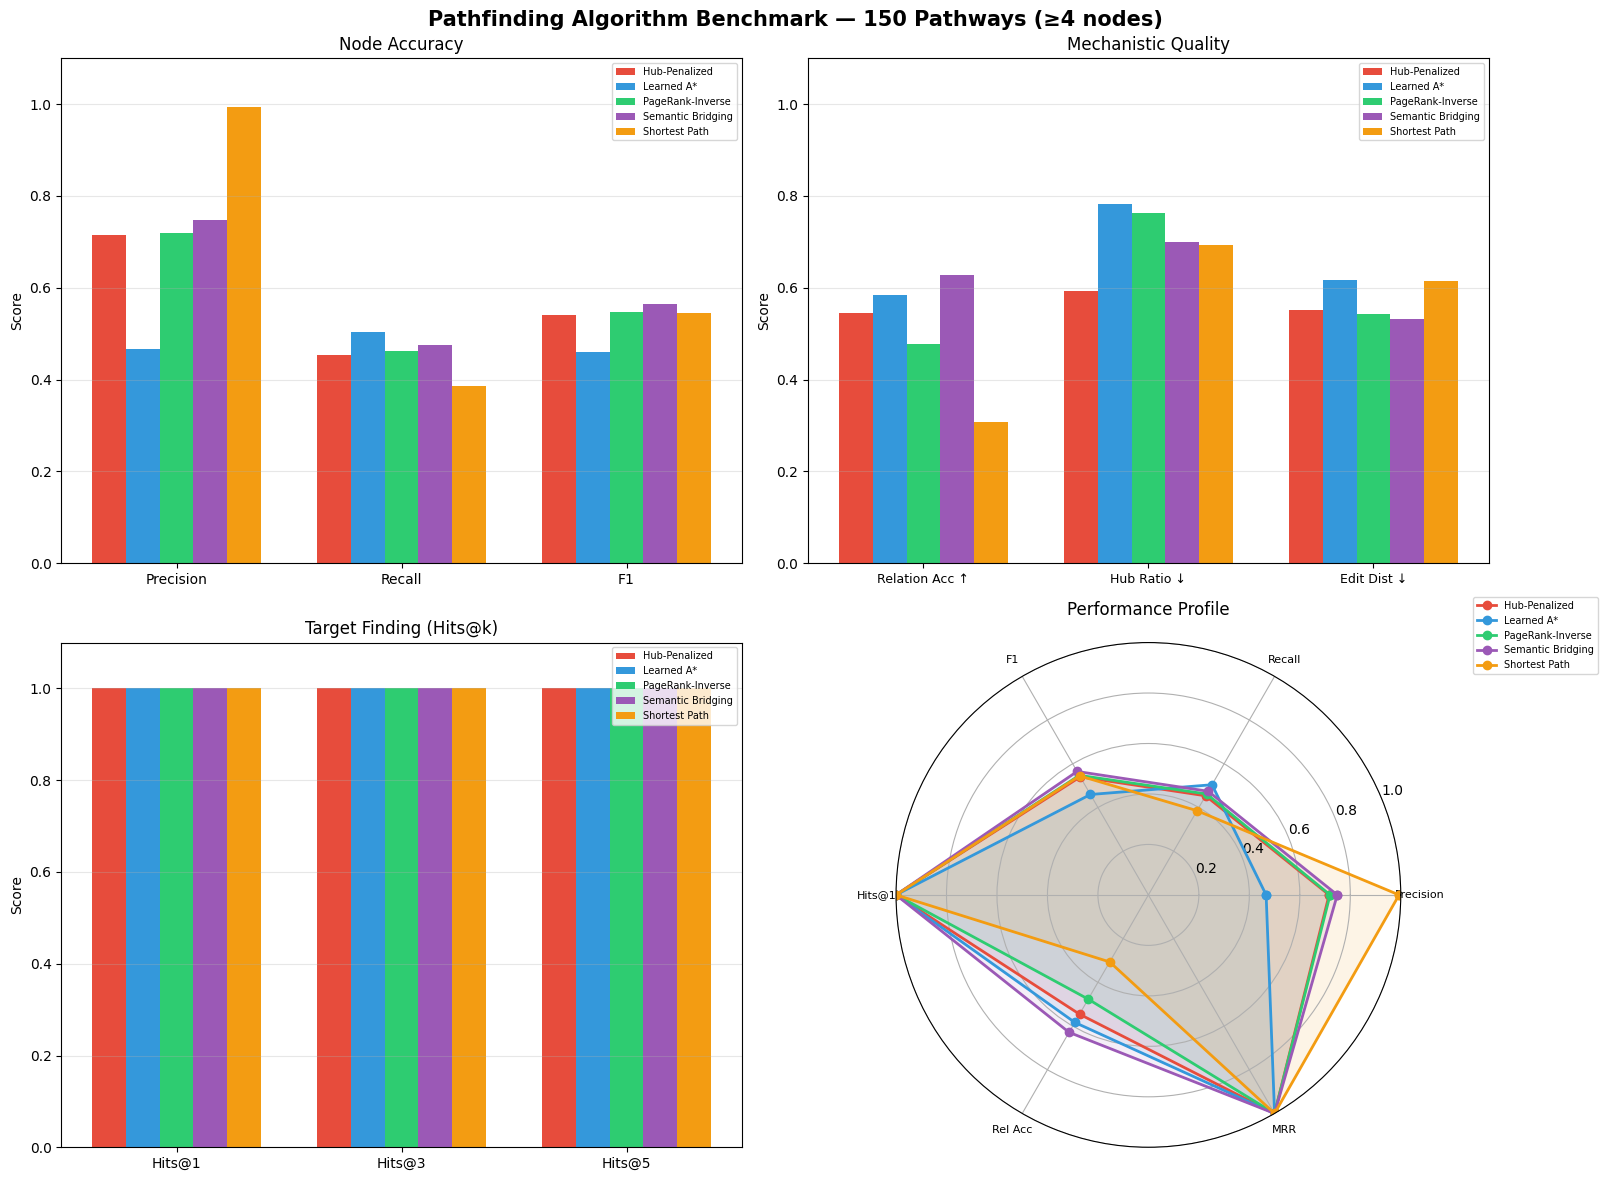

In [46]:
# ============================================================
# VISUALIZATION: Multi-panel comparison
# ============================================================

algo_names = list(summary.index)
n_algos = len(algo_names)
colors_list = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12'][:n_algos]
color_map = dict(zip(algo_names, colors_list))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Pathfinding Algorithm Benchmark — {eval_df["pathway_id"].nunique()} Pathways (≥{MIN_PATHWAY_NODES} nodes)',
             fontsize=15, fontweight='bold')

# --- 1. Node Accuracy ---
ax = axes[0, 0]
node_metrics = ['precision', 'recall', 'f1_score']
x = np.arange(len(node_metrics))
width = 0.15
for i, alg in enumerate(algo_names):
    vals = [summary.loc[alg, m] for m in node_metrics]
    ax.bar(x + i * width, vals, width, label=alg, color=color_map[alg])
ax.set_ylabel('Score')
ax.set_title('Node Accuracy')
ax.set_xticks(x + width * (n_algos - 1) / 2)
ax.set_xticklabels(['Precision', 'Recall', 'F1'])
ax.legend(fontsize=7)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# --- 2. Mechanistic Quality ---
ax = axes[0, 1]
mech_metrics = ['relation_type_accuracy', 'hub_node_ratio', 'path_edit_distance']
x = np.arange(len(mech_metrics))
for i, alg in enumerate(algo_names):
    vals = [summary.loc[alg, m] for m in mech_metrics]
    ax.bar(x + i * width, vals, width, label=alg, color=color_map[alg])
ax.set_ylabel('Score')
ax.set_title('Mechanistic Quality')
ax.set_xticks(x + width * (n_algos - 1) / 2)
ax.set_xticklabels(['Relation Acc ↑', 'Hub Ratio ↓', 'Edit Dist ↓'], fontsize=9)
ax.legend(fontsize=7)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# --- 3. Target Finding ---
ax = axes[1, 0]
hits_metrics = ['hits_at_1', 'hits_at_3', 'hits_at_5']
x = np.arange(len(hits_metrics))
for i, alg in enumerate(algo_names):
    vals = [summary.loc[alg, m] for m in hits_metrics]
    ax.bar(x + i * width, vals, width, label=alg, color=color_map[alg])
ax.set_ylabel('Score')
ax.set_title('Target Finding (Hits@k)')
ax.set_xticks(x + width * (n_algos - 1) / 2)
ax.set_xticklabels(['Hits@1', 'Hits@3', 'Hits@5'])
ax.legend(fontsize=7)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# --- 4. Radar Chart ---
axes[1, 1].set_visible(False)
ax_radar = fig.add_subplot(2, 2, 4, projection='polar')

radar_metrics = ['precision', 'recall', 'f1_score', 'hits_at_1', 'relation_type_accuracy', 'mrr']
radar_labels = ['Precision', 'Recall', 'F1', 'Hits@1', 'Rel Acc', 'MRR']

angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
angles += angles[:1]

for alg in algo_names:
    vals = [summary.loc[alg, m] for m in radar_metrics] + [summary.loc[alg, radar_metrics[0]]]
    ax_radar.plot(angles, vals, 'o-', linewidth=2, label=alg, color=color_map[alg])
    ax_radar.fill(angles, vals, alpha=0.1, color=color_map[alg])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(radar_labels, fontsize=8)
ax_radar.set_ylim(0, 1)
ax_radar.set_title('Performance Profile', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1), fontsize=7)

plt.tight_layout()
plt.savefig('algorithm_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: algorithm_comparison.png")
plt.show()


✓ Saved: timing_comparison.png


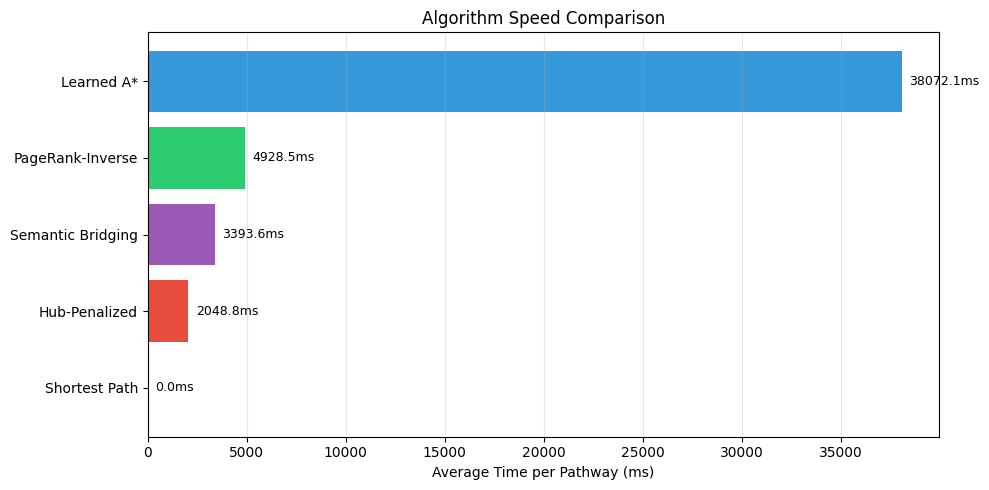

In [47]:
# ============================================================
# TIMING COMPARISON
# ============================================================

avg_times = eval_df.groupby('algorithm')['time_ms'].mean().sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(avg_times.index, avg_times.values, color=[color_map.get(a, '#999') for a in avg_times.index])
ax.set_xlabel('Average Time per Pathway (ms)')
ax.set_title('Algorithm Speed Comparison')
for bar, val in zip(bars, avg_times.values):
    ax.text(bar.get_width() + max(avg_times.values)*0.01, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}ms', va='center', fontsize=9)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('timing_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: timing_comparison.png")
plt.show()


## 12. Performance by Pathway Length

Analyze whether algorithm performance varies with ground truth pathway length.


Pathway count by length:
  4 nodes: 60 pathways
  5 nodes: 36 pathways
  6 nodes: 15 pathways
  7+ nodes: 39 pathways

Mean F1 by pathway length:
length_bucket      4 nodes  5 nodes  6 nodes  7+ nodes
algorithm                                             
Hub-Penalized       0.6159   0.6343   0.5185    0.3456
Learned A*          0.5124   0.5353   0.3997    0.3312
PageRank-Inverse    0.6460   0.6111   0.5333    0.3417
Semantic Bridging   0.6428   0.6458   0.5630    0.3711
Shortest Path       0.6667   0.5694   0.5000    0.3517

✓ Saved: f1_by_length.png


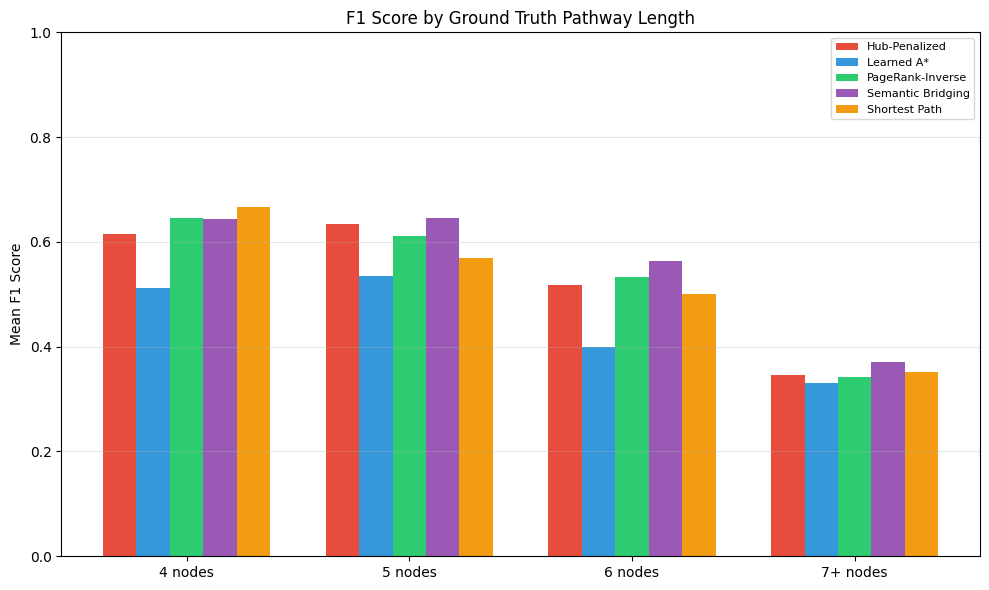

In [48]:
# Add ground truth length to eval_df for grouping
eval_with_len = eval_df.copy()

# Make sure ground truth length is available
gt_len_map = gt_nodes_df.groupby('pathway_id').size().to_dict()
eval_with_len['gt_length'] = eval_with_len['pathway_id'].map(gt_len_map)

# Group by length bucket
eval_with_len['length_bucket'] = eval_with_len['gt_length'].apply(
    lambda x: '4 nodes' if x == 4 else ('5 nodes' if x == 5 else ('6 nodes' if x == 6 else '7+ nodes'))
)

print("Pathway count by length:")
for bucket in ['4 nodes', '5 nodes', '6 nodes', '7+ nodes']:
    count = eval_with_len[eval_with_len['length_bucket'] == bucket]['pathway_id'].nunique()
    if count > 0:
        print(f"  {bucket}: {count} pathways")

# F1 by length and algorithm
print("\nMean F1 by pathway length:")
pivot = eval_with_len.pivot_table(index='algorithm', columns='length_bucket', values='f1_score', aggfunc='mean').round(4)
print(pivot.to_string())

# Plot F1 by length
fig, ax = plt.subplots(figsize=(10, 6))
buckets = [b for b in ['4 nodes', '5 nodes', '6 nodes', '7+ nodes'] if b in pivot.columns]
x = np.arange(len(buckets))
width = 0.15

for i, alg in enumerate(algo_names):
    if alg in pivot.index:
        vals = [pivot.loc[alg, b] if b in pivot.columns else 0 for b in buckets]
        ax.bar(x + i * width, vals, width, label=alg, color=color_map[alg])

ax.set_ylabel('Mean F1 Score')
ax.set_title('F1 Score by Ground Truth Pathway Length')
ax.set_xticks(x + width * (n_algos - 1) / 2)
ax.set_xticklabels(buckets)
ax.legend(fontsize=8)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('f1_by_length.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: f1_by_length.png")
plt.show()


## 13. Detailed Pathway Analysis (Sample)

Inspect a sample of individual pathway results across all algorithms. Shows first 10 pathways.


In [49]:
print("=" * 80)
print("DETAILED PATHWAY ANALYSIS (first 10 pathways)")
print("=" * 80)

algo_list = list(all_predictions.keys())
sample_pathways = gt_nodes_df['pathway_id'].unique()[:10]

for pathway_id in sample_pathways:
    print(f"\n{'=' * 70}")
    print(f"Pathway: {pathway_id}")
    print(f"{'=' * 70}")

    # Ground truth
    gt = gt_nodes_df[gt_nodes_df['pathway_id'] == pathway_id].sort_values('step_order')
    gt_path = ' → '.join(gt['node_name'].tolist())
    gt_types = ' → '.join(gt['node_type'].tolist())
    print(f"\n  Ground Truth ({len(gt)} nodes):")
    print(f"    {gt_path}")
    print(f"    Types: {gt_types}")

    # Each algorithm
    for alg_name in algo_list:
        pred = all_predictions[alg_name]
        row = pred[pred['pathway_id'] == pathway_id]
        if row.empty:
            continue
        row = row.iloc[0]
        if row['predicted_node_names'] != 'NONE':
            pred_path = row['predicted_node_names'].replace(',', ' → ')
            n_nodes = row['predicted_length']
        else:
            pred_path = '(no path found)'
            n_nodes = 0
        print(f"\n  {alg_name} ({n_nodes} nodes, {row['time_ms']:.1f}ms):")
        print(f"    {pred_path}")

    # Metrics table
    pw_eval = eval_df[eval_df['pathway_id'] == pathway_id]
    if not pw_eval.empty:
        show_metrics = ['f1_score', 'relation_type_accuracy', 'path_edit_distance', 'hub_node_ratio']
        header = f"  {'Metric':<28s}" + "".join(f"{a:>18s}" for a in algo_list)
        print(f"\n{header}")
        print(f"  {'-' * (28 + 18 * len(algo_list))}")
        for metric in show_metrics:
            row_str = f"  {metric:<28s}"
            for alg in algo_list:
                val = pw_eval[pw_eval['algorithm'] == alg][metric].values
                row_str += f"{val[0]:>18.3f}" if len(val) > 0 else f"{'N/A':>18s}"
            print(row_str)


DETAILED PATHWAY ANALYSIS (first 10 pathways)

Pathway: diflunisal_Rheumatoid_arthritis

  Ground Truth (5 nodes):
    diflunisal → Prostaglandin G/H synthase 2 → inflammatory response → Prostaglandin G/H synthase 1 → Rheumatoid arthritis
    Types: drug → gene/protein → biological_process → gene/protein → disease

  Shortest Path (2 nodes, 0.3ms):
    Diflunisal → rheumatoid arthritis

  Hub-Penalized (3 nodes, 313.0ms):
    Diflunisal → PTGS1 → rheumatoid arthritis

  PageRank-Inverse (3 nodes, 2814.6ms):
    Diflunisal → Fever → rheumatoid arthritis

  Learned A* (5 nodes, 107.8ms):
    Diflunisal → PTGS2 → positive regulation of apoptotic process → TXNIP → rheumatoid arthritis

  Semantic Bridging (3 nodes, 2060.8ms):
    Diflunisal → PTGS2 → rheumatoid arthritis

  Metric                           Shortest Path     Hub-Penalized  PageRank-Inverse        Learned A* Semantic Bridging
  --------------------------------------------------------------------------------------------------

## 14. Export Results

In [50]:
# Save evaluation results
eval_df.to_csv('evaluation_results_all_algorithms.csv', index=False)
print(f"✓ Saved: evaluation_results_all_algorithms.csv ({len(eval_df)} rows)")

# Save summary
summary.to_csv('algorithm_summary.csv')
print("✓ Saved: algorithm_summary.csv")

# Save per-algorithm predictions
for alg_name, pred_df in all_predictions.items():
    fname = f"predictions_{alg_name.lower().replace(' ', '_').replace('*', 'star')}.csv"
    pred_df.to_csv(fname, index=False)
    print(f"✓ Saved: {fname} ({len(pred_df)} rows)")

print(f"\n✓ All outputs saved! ({eval_df['pathway_id'].nunique()} pathways × {eval_df['algorithm'].nunique()} algorithms)")


✓ Saved: evaluation_results_all_algorithms.csv (750 rows)
✓ Saved: algorithm_summary.csv
✓ Saved: predictions_shortest_path.csv (150 rows)
✓ Saved: predictions_hub-penalized.csv (150 rows)
✓ Saved: predictions_pagerank-inverse.csv (150 rows)
✓ Saved: predictions_learned_astar.csv (150 rows)
✓ Saved: predictions_semantic_bridging.csv (150 rows)

✓ All outputs saved! (150 pathways × 5 algorithms)


In [1]:
## Fine tuning algo's 4 and 5

# Improvement Strategy: Algorithms 4 & 5

## Learned A* (Algorithm 4) — Problems
- **Learns one "average path" (~6 nodes)** — edge features are purely local, MLP has no sense of position in the path or how far from the target
- **Spectral embeddings capture topology, not biology** — Laplacian eigenvectors encode community structure, but MoA pathways deliberately cross communities (drug → protein → process → disease)
- **Train-on-test leakage** — trains and evaluates on the same 150 pathways

## Learned A* — Fixes
- Add **path-level context** to edge features: hop count from source, distance to target, current node type
- Replace spectral embeddings with **node-type-aware features** (one-hot source/target type pairs)
- Implement **k-fold cross-validation** to eliminate leakage
- **Constrain A\* to valid meta-path prefixes** — only expand edges consistent with known GT patterns

---

## Semantic Bridging (Algorithm 5) — Problems
- **TF-IDF on gene symbols is meaningless** — "CHRNA3" and "BCL2L1" have no semantic content; only descriptive names like "inflammatory response" produce useful similarity
- **Still routes through side effects** (11.5% `drug_effect` edges) — cosine similarity between drug and side-effect names can be high
- **Single global β=0.3** — same discount everywhere, but early edges (drug→protein) and late edges (process→disease) need different treatment

## Semantic Bridging — Fixes
- Replace TF-IDF with **biomedical embeddings** (BioWordVec/PubMedBERT) or **graph co-occurrence features** from PrimeKG neighbor overlap
- Use **per-edge-type weights** learned from GT frequency — penalize `drug_effect`, reward `drug_protein`/`bioprocess_protein`
- Add **soft meta-path penalties** — multiply weight by 10x if edge type doesn't match any valid prefix

---

## Shared Lever: Meta-Path Awareness
- **Biggest single improvement for both algorithms** — mine the dominant edge-type patterns from 150 ground truths and use them as soft/hard constraints
- Both algorithms are currently blind to whether a path's edge-type sequence is biologically plausible